In [1]:
%load_ext autoreload
%autoreload 2

# Stable Diffusion desde cero - Parte 1

El campo de la Inteligencia Artificial Generative (*GenAI*) está más de moda que nunca, con resultados tan impresionantes como los que están proporcionando (ChatGPT)[https://chat.openai.com/chat] en la generación de texto o [DALL-E](https://openai.com/dall-e-2/) en la generación de imágenes. Saber cómo funcionan estos modelos es importante si no queremos quedarnos al márgen de la innovación y convertirnos en simples consumidores de tecnología (con el peligro que ello conlleva si tenemos en cuenta la desinformación que pueden generar estos sistemas). Así pues, con este post arrancamos una nueva serie en las que aprenderemos sobre generación de imágenes implementandop [Stable Diffusion](https://es.wikipedia.org/wiki/Stable_Diffusion) desde cero. !Vamos allá!

> En estos posts no vamos a entrar en muchos detalles matemáticos ni en el porqué de si hacemos las cosas como os voy a explicar funcionan y si no, no. Para ello os dejo al final una lista de recursos muy interesantes en el que os podréis meter de lleno en el tema con todas las ecuaciones y pruebas que queráis :)

## Generando de imágenes a partir de ruido.

Nuestro principal objetivo es el de generar imágenes convincentes de manera estocástica, a partir de ruido. En este primer post nos centramos simplemente la parte de generación de imágenes, más adelante veremos cómo poder "guiar" este proceso mediante texto para generar imágenes con un contenido concreto.

Para empezar, usaremos nuestro querido datasets MNIST ya que su tamaño es simplicidad es perfecto para poder hacer pruebas y experimentar de manera rápida.

In [69]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

# importante que las imágenes estén en el rango -1, 1
X, y = 2. * (mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255.) - 1., mnist["target"].values.astype(int)

X.shape, y.shape

((70000, 28, 28), (70000,))

In [70]:
X.min(), X.max()

(-1.0, 1.0)

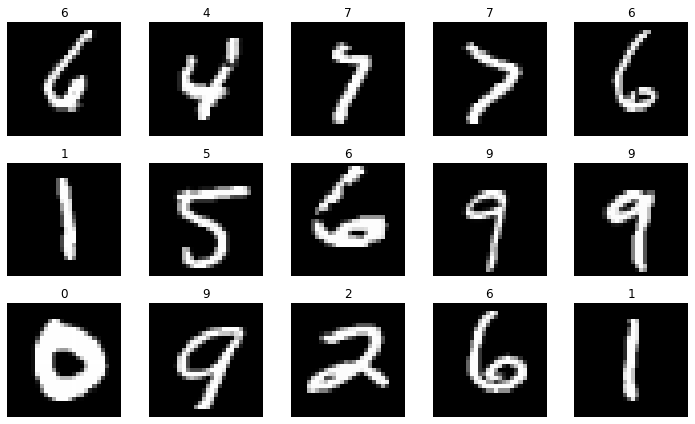

In [101]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow(X[ix], cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

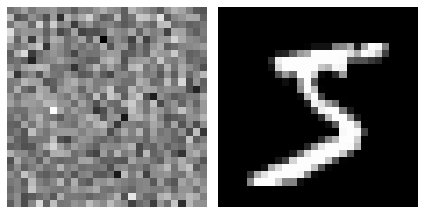

In [102]:
import torch 

fig = plt.figure()
ax = plt.subplot(1, 2, 1)
noise = torch.randn(28, 28)
ax.imshow(noise, cmap='gray')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
sample = torch.from_numpy(X[0])
ax.imshow(sample, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()

¿Cómo podemos entrenar un modelo que sea capaz de recibir a la entrada algo como lo de la izquierda y generar algo como lo de la derecha? La idea fundamental se basa en entrenar un modelo que sea capaz de predecir de la manera más precisa posible el ruido en una imagen. Si somos capaces de resolver esta tarea podremos restar a la imagen de la entrada el ruido predicho por el modelo obteniendo así una imagen realista. Durante el entrenamiento generaremos versiones ruidosas de nuestras muestras y entrenaremos el modelo a predecir el ruido añadido.

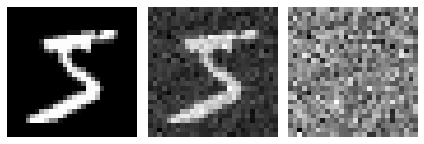

In [103]:
noise = torch.randn(28, 28) * 0.2

fig = plt.figure()
ax = plt.subplot(1, 3, 1)
ax.imshow(sample, cmap='gray')
ax.axis('off')
ax = plt.subplot(1, 3, 2)
ax.imshow(sample + noise, cmap='gray')
ax.axis('off')
ax = plt.subplot(1, 3, 3)
ax.imshow(noise, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()

Si bien la idea es simple, para que funcione tenemos que añadir el ruido a nuestras imágenes de una manera en concreto. En el caso de Stable Diffusion, basado en [este paper](https://arxiv.org/abs/2112.10752), se añade ruido de manera progresiva asegurándonos que, al final del proceso, la imagen equivaldrá a una distribución gaussiana con media 0 y desviación estándar 1. A la hora de generar imágenes en fase de inferencia, repetiremos el proceso pero a la inversa.

$$
q(x_t|x_{t-1}) = N(x_t;\sqrt{1 - \beta_t} x_{t-1}, \beta_t I)
$$

La manera en la que introducimos ruido se denomina como *`Noise Scheduler`*, y es lo que diferencia a los diferentes modelos basados en difusión entre sí.

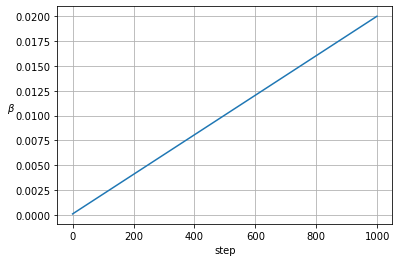

In [113]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	return torch.linspace(start, end, steps)

betas = noise_scheduler()

plt.plot(betas)
plt.xlabel('step')
plt.ylabel('$\\beta$', rotation=0)
plt.grid()
plt.show()

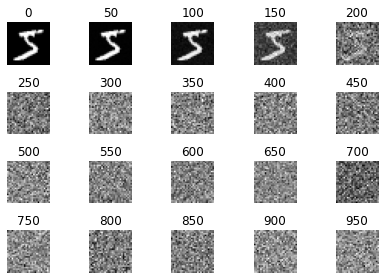

In [119]:
fig = plt.figure()
rs, cs = 4, 5
x = sample
i = 0
for t in range(1000):
	x = torch.randn(28, 28) * betas[t] + x * torch.sqrt(1. - torch.sqrt(betas[t]))
	if t % 50 == 0:
		i += 1
		ax = plt.subplot(rs, cs, i)
		ax.imshow(x, cmap='gray')
		ax.axis('off')
		ax.set_title(t)
plt.tight_layout()
plt.show()

# El Modelo

Como hemos visto anteriormente, el modelo se encargará de predecir el ruido que se ha añadido a la imagen de entrada. En principio podríamos usar cualquier arquitectura de red neuronal que sea capaz de resolver esta tarea. En el caso de Stable Diffusion, la solución adpotada es la de la red conocida como [UNet](https://arxiv.org/abs/1505.04597). 

> En este post no entraremos en detalles acerca de este modelo, ya que lo hemos visto en detalle en posts anteriores. [Aquí](https://juansensio.com/blog/050_cv_segmentacion) tienes un ejemplo de implementación de UNet en PyTorch.

Además, para que el modelo sea capaz de distinguir el `step` en el que nos encontramos añadiremos esta información mediante una capa de `embedding`.

In [120]:
from unet import UNet
import math
import torch

class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        half_dim = dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        self.register_buffer('embeddings', embeddings)

    def forward(self, time):
        embeddings = time[:, None] * self.embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DiffusionModel(torch.nn.Module):
	def __init__(self, t_dim=32, t_out=28):
		super().__init__()
		self.time_mlp = torch.nn.Sequential(
            SinusoidalPositionEmbeddings(t_dim),
            torch.nn.Linear(t_dim, t_out),
            torch.nn.ReLU()
        )
		self.unet = UNet()
		self.t_out = t_out

	def forward(self, x, t):
		B, C, H, W = x.shape
		t = self.time_mlp(t)
		t = t.repeat(1, 1, self.t_out).reshape(B, 1, self.t_out, self.t_out)
		x = x + t
		x = self.unet(x)
		return torch.tanh(x)

model = DiffusionModel()
output = model(torch.randn(10, 1, 28, 28), torch.randint(0, 1000, (10, 1)))
output.shape

torch.Size([10, 1, 28, 28])

Durante el entrenamiento, alimentaremos a nuestro modelo con un batch de imágenes perturbadas por ruido. Para ello escogeremos de manera aleatoria un valor del `step` para nuestro `noise scheduler` y añadiremos el ruido correspondiente como hemos visto antes. Iterar para cada muestra hasta conseguir el resultado deseado puede resultar costoso, especialmente para valores de `step` altos. Para ello usamos una formulación equivalente pero que nos permite calcular el ruido de manera más eficiente en un solo paso.

$$
q(x_t|x_{0}) = N(x_t;\sqrt{\hat{\alpha_t}} x_{0}, (1-\hat{\alpha_t})I)
$$

donde $\hat{\alpha_t}$ son valores pre-calculados a partir de $\beta_t$.

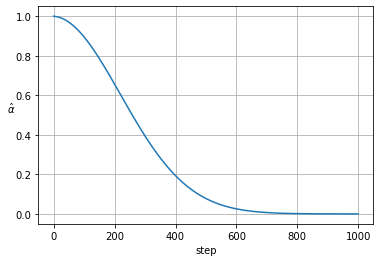

In [129]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_cumprod = torch.cumprod(alphas, axis=0)
	# alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
	# sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
	# sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
	return alphas_cumprod

alphas = noise_scheduler()

plt.plot(alphas)
plt.xlabel('step')
plt.ylabel('$\\hat{\\alpha}$', rotation=0)
plt.grid()
plt.show()

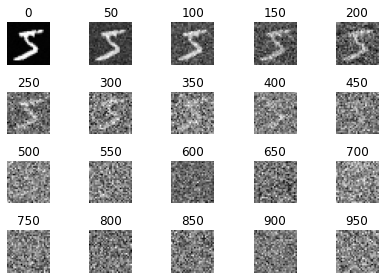

In [131]:
fig = plt.figure()
rs, cs = 4, 5
for i in range(rs*cs):
	ax = plt.subplot(rs, cs, i+1)
	j = 50*i
	x = torch.randn(28, 28) * torch.sqrt(1 - alphas[j]) + sample * torch.sqrt(alphas[j])
	ax.imshow(x, cmap='gray')
	ax.axis('off')
	ax.set_title(j)
plt.tight_layout()
plt.show()

Ahora ya podemos definir nuestro `Dataset` para entrenar el modelo.

In [133]:
import numpy as np 

class Dataset(torch.utils.data.Dataset):
	def __init__(self, X, T=1000):
		self.X = X
		self.T = T
		self.alphas = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, ix):
		im = torch.from_numpy(self.X[ix])
		t = torch.randint(0, self.T, (1,))
		noise = torch.randn_like(im)
		x = noise * torch.sqrt(1 - self.alphas[t]) + im * torch.sqrt(self.alphas[t]) 
		return x.unsqueeze(0).float(), noise.unsqueeze(0).float(), t

Fit one batch

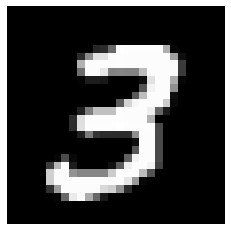

In [142]:
ds = Dataset(X[y == 3], 1000) # usamos solo los 3s

plt.imshow(ds.X[0], cmap='gray')
plt.axis('off')
plt.show()

In [153]:
import tqdm 

EPOCHS = 1000
BATCH_SIZE = 10

ds = Dataset(X[y == 3], 1000) # usamos solo los 3s
# dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
model = DiffusionModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

model.train()
pb = tqdm.tqdm(range(1, EPOCHS+1))
# for epoch in range(1, EPOCHS+1):
for epoch in pb:
	losses = []
	# pb = tqdm.tqdm(dl)
	# for im, noise, t in pb:
	for im, noise, t in dl:
		im, noise, t = im.cuda(), noise.cuda(), t.cuda()
		output = model(im, t)
		loss = torch.nn.functional.mse_loss(output, noise)
		# loss = torch.nn.functional.l1_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		break
	pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 1000/1000 loss 0.18916: 100%|██████████| 1000/1000 [00:10<00:00, 92.71it/s]


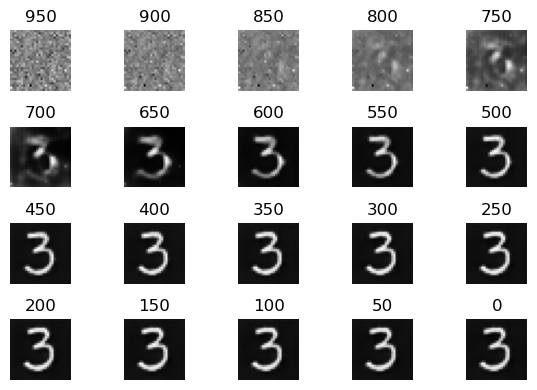

In [156]:
ITS = 1000
C = 0.01

model.eval()

input = torch.randn(1, 1, 28, 28).cuda() 

# ix = random.randint(0, len(ds)-1)
# im, noise, _ = ds[ix]
# input = im.cuda().unsqueeze(0) + noise.cuda().unsqueeze(0)

r, c = 4, 5
fig = plt.figure(dpi=100)
i = 0
for t in reversed(range(ITS)):
	with torch.no_grad():
		output = model(input, torch.tensor([[t]]).cuda())
	input = input - output * C
	# input = 1. / torch.sqrt(alphas[t]) * (input - output * ((1 - alphas[t])/(torch.sqrt(1 - alphas[t]))))
	if t % 50 == 0:
		i += 1
		ax = plt.subplot(r, c, i)
		ax.imshow(input[0][0].cpu().numpy(), cmap='gray')
		ax.axis("off")
		ax.set_title(t)
plt.tight_layout()
plt.show()

In [157]:
import tqdm

EPOCHS = 10
BATCH_SIZE = 32

ds = Dataset(X) # usamos todo el dataset
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
model = DiffusionModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
	losses = []
	pb = tqdm.tqdm(dl)
	for im, noise, t in pb:
		im, noise, t = im.cuda(), noise.cuda(), t.cuda()
		output = model(im, t)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 10/10 loss 0.17196: 100%|██████████| 2188/2188 [00:25<00:00, 86.96it/s]


In [163]:
ITS = 1000
C = 0.01

model.eval()
input = torch.randn(1, 1, 28, 28).cuda() 
r, c = 4, 5
fig = plt.figure(dpi=100)
i = 0
for t in reversed(range(ITS)):
	with torch.no_grad():
		output = model(input, torch.tensor([[t]]).cuda())
	input = input - output * C
	# input = 1. / torch.sqrt(alphas[t]) * (input - output * ((1 - alphas[t])/(torch.sqrt(1 - alphas[t]))))
	if t % 50 == 0:
		i += 1
		ax = plt.subplot(r, c, i)
		ax.imshow(input[0][0].cpu().numpy(), cmap='gray')
		ax.axis("off")
		ax.set_title(t)
plt.tight_layout()
plt.show()